# Start here, basic imports

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [1]:
from train import *
import shlex
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import scipy

In [4]:
def get_entropy_curve(all_timesteps_logits):
    # all_timesteps_logits : b x num_timesteps x num_logits 
    # returns: shannon_entropies : bs x num_timesteps
    probs = torch.nn.functional.softmax(all_timesteps_logits, dim=-1)
    shannon_entropies = (-probs * torch.log2(probs)).sum(axis=-1)
    return shannon_entropies

def get_probs(all_timesteps_logits):
    # all_timesteps_logits : b x num_timesteps x num_logits 
    # returns: probs : bs x num_timesteps x num_logits
    probs = torch.nn.functional.softmax(all_timesteps_logits, dim=-1)
    return probs

- Command to run the main training file

python train.py -cfg dalernn-t-12-gate-ln-relu -nl 3 --epochs 5 -b 256 --lr 1e-4 --rank 0 --world-size 1 --gpu 0 --data /home/vveeraba/src/pathfinder_full/curv_contour_length_14 -wd 0 --in-res 160 --expname pf14_channels32_fsize7 --seed 10

# Error analysis of original model

In [ ]:
cmd = 'train.py -cfg dalernn-t-12-gate-ln-relu -nl 3 --doEntropyThresholding 0 --returnValidOutput 1 --epochs 5 -b 256 --lr 1e-4 --rank 0 --world-size 1 --gpu 0 -wd 0 --in-res 160 --expname pf14_channels32_fsize7 --seed 10'
args = parser.parse_args(shlex.split(cmd))
args.cfg = load_cfg(args)
args.cfg['nlayers'] = args.nlayers
args.cfg['in_res'] = args.in_res
args.data = '/home/vveeraba/src/pathfinder_full/curv_contour_length_14'

# Data loading code
traindir = os.path.join(args.data, 'train')
valdir = os.path.join(args.data, 'val')

# Load val data
val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize(args.in_res),
            transforms.ToTensor(),
        ])),
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)

In [ ]:
# Load existing checkpoint
print("=> loading checkpoint '{}'".format(args.resume))
# Map model to be loaded to specified single gpu.
loc = 'cuda:0'
checkpoint_file = 'ckpt_iclr/curv_contour_length_14/dalernn_gate_ln_relu/pf14_channels32_fsize7_grmfwu_seed_10/pathfinder_checkpoint_best_dalernn_gate_ln_relu.pth'  # Without entropy thresholding
checkpoint = torch.load(checkpoint_file, map_location=loc)
best_acc1 = checkpoint['val_acc1']
# create model
num_classes = 2
args.cfg = create_config(args.cfg)
model = BaseModel(args.cfg, args)
model_name = args.cfg.name  # + str(args.cfg.nlayers)
args.model_name = model_name
model.cuda()
model.load_state_dict(checkpoint['model'])

criterion = nn.CrossEntropyLoss().cuda(args.gpu)
optimizer = torch.optim.Adam(model.parameters(), args.lr,
                             # momentum=args.momentum,
                             # weight_decay=args.weight_decay
                             )
optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
val_acc1, (outputs, full_outputs, targets) = validate(val_loader, model, criterion, optimizer=None, epoch=None, args=args)

In [ ]:
full_outputs = torch.transpose(full_outputs, 1, 0)

In [ ]:
(outputs.argmax(dim=-1) != targets).sum()

In [ ]:
(((outputs.argmax(dim=-1) != targets)) * (targets==0)).sum(), (((outputs.argmax(dim=-1) != targets)) * (targets==1)).sum()

In [ ]:
(((outputs.argmax(dim=-1) == targets)) * (targets==0)).sum(), (((outputs.argmax(dim=-1) == targets)) * (targets==1)).sum()

In [ ]:
entropies = get_entropy_curve(full_outputs)
probs = get_probs(full_outputs)

In [ ]:
incorrect_gt_false_idxs = torch.where(((outputs.argmax(dim=-1) != targets)) * (targets==0))[0]
incorrect_gt_true_idxs = torch.where(((outputs.argmax(dim=-1) != targets)) * (targets==1))[0]
correct_gt_false_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==0))[0]
correct_gt_true_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==1))[0]

In [ ]:
incorrect_gt_true_entropies = entropies[incorrect_gt_true_idxs]
incorrect_gt_false_entropies = entropies[incorrect_gt_false_idxs]
correct_gt_true_entropies = entropies[correct_gt_true_idxs]
correct_gt_false_entropies = entropies[correct_gt_false_idxs]

incorrect_gt_true_probs = probs[incorrect_gt_true_idxs][:, :, 1]
incorrect_gt_false_probs = probs[incorrect_gt_false_idxs][:, :, 0]
correct_gt_true_probs = probs[correct_gt_true_idxs][:, :, 1]
correct_gt_false_probs = probs[correct_gt_false_idxs][:, :, 0]

In [ ]:
plt.figure(figsize=(6,1))
plt.title('Entropy, Prob curve for incorrect, gt true {}'.format(incorrect_gt_true_entropies.shape[0]))
means = incorrect_gt_true_entropies.mean(axis=0).cpu().numpy()
stds = incorrect_gt_true_entropies.std(axis=0).cpu().numpy()
plt.errorbar(range(12), means, yerr=stds)
means = incorrect_gt_true_probs.mean(axis=0).cpu().numpy()
stds = incorrect_gt_true_probs.std(axis=0).cpu().numpy()
plt.errorbar(range(12), means, yerr=stds)

plt.figure(figsize=(6,1))
plt.title('Entropy, Prob curve for incorrect, gt false {}'.format(incorrect_gt_false_entropies.shape[0]))
means = incorrect_gt_false_entropies.mean(axis=0).cpu().numpy()
stds = incorrect_gt_false_entropies.std(axis=0).cpu().numpy()
plt.errorbar(range(12), means, yerr=stds)
means = incorrect_gt_false_probs.mean(axis=0).cpu().numpy()
stds = incorrect_gt_false_probs.std(axis=0).cpu().numpy()
plt.errorbar(range(12), means, yerr=stds)

plt.figure(figsize=(6,1))
plt.title('Entropy, Prob curve for correct, gt true {}'.format(correct_gt_true_entropies.shape[0]))
means = correct_gt_true_entropies.mean(axis=0).cpu().numpy()
stds = correct_gt_true_entropies.std(axis=0).cpu().numpy()
plt.errorbar(range(12), means, yerr=stds)
means = correct_gt_true_probs.mean(axis=0).cpu().numpy()
stds = correct_gt_true_probs.std(axis=0).cpu().numpy()
plt.errorbar(range(12), means, yerr=stds)

plt.figure(figsize=(6,1))
plt.title('Entropy, Prob curve for correct, gt false {}'.format(correct_gt_false_entropies.shape[0]))
means = correct_gt_false_entropies.mean(axis=0).cpu().numpy()
stds = correct_gt_false_entropies.std(axis=0).cpu().numpy()
plt.errorbar(range(12), means, yerr=stds)
means = correct_gt_false_probs.mean(axis=0).cpu().numpy()
stds = correct_gt_false_probs.std(axis=0).cpu().numpy()
plt.errorbar(range(12), means, yerr=stds)


# Entropy cutoff experiments

- When picking timestep with minimum entropy (just during validation, no change in training), performance drops from 91% to 81%.
- For random samples, analyze the entropy curve with timesteps. 

In [ ]:
cmd = 'train.py -cfg dalernn-t-12-gate-ln-relu -nl 3 --doEntropyThresholding 1 --returnValidOutput 1 --epochs 5 -b 256 --lr 1e-4 --rank 0 --world-size 1 --gpu 0 -wd 0 --in-res 160 --expname pf14_channels32_fsize7 --seed 10'
args = parser.parse_args(shlex.split(cmd))
args.cfg = load_cfg(args)
args.cfg['nlayers'] = args.nlayers
args.cfg['in_res'] = args.in_res
args.data = '/home/vveeraba/src/pathfinder_full/curv_contour_length_14'

# Data loading code
traindir = os.path.join(args.data, 'train')
valdir = os.path.join(args.data, 'val')

# Load val data
val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize(args.in_res),
            transforms.ToTensor(),
        ])),
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)

In [ ]:
# Load existing checkpoint
print("=> loading checkpoint '{}'".format(args.resume))
# Map model to be loaded to specified single gpu.
loc = 'cuda:0'
checkpoint_file = 'ckpt_iclr/curv_contour_length_14/dalernn_gate_ln_relu/pf14_channels32_fsize7_vgnrnr_seed_10/pathfinder_checkpoint_best_dalernn_gate_ln_relu.pth'  # With entropy thresholding
# checkpoint_file = 'ckpt_iclr/curv_contour_length_14/dalernn_gate_ln_relu/pf14_channels32_fsize7_grmfwu_seed_10/pathfinder_checkpoint_best_dalernn_gate_ln_relu.pth'  # Without entropy thresholding
checkpoint = torch.load(checkpoint_file, map_location=loc)
best_acc1 = checkpoint['val_acc1']
# create model
num_classes = 2
args.cfg = create_config(args.cfg)
model = BaseModel(args.cfg, args)
model_name = args.cfg.name  # + str(args.cfg.nlayers)
args.model_name = model_name
model.cuda()
model.load_state_dict(checkpoint['model'])

criterion = nn.CrossEntropyLoss().cuda(args.gpu)
optimizer = torch.optim.Adam(model.parameters(), args.lr,
                             # momentum=args.momentum,
                             # weight_decay=args.weight_decay
                             )
optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
val_acc2, (outputs2, full_outputs2, targets2) = validate(val_loader, model, criterion, optimizer=None, epoch=None, args=args)

In [ ]:
full_outputs2 = torch.transpose(full_outputs2, 1, 0)

- Where do these outputs differ? i.e, where did the entropy thresholding go wrong (and right). We first investigate the examples  where entropy thresholding wrong, old one was right.

In [ ]:
print(((outputs.argmax(dim=-1) == targets) * ((outputs2.argmax(dim=-1) != targets2))).sum())
print(((outputs.argmax(dim=-1) != targets) * ((outputs2.argmax(dim=-1) == targets2))).sum())
print(((outputs.argmax(dim=-1) != targets) * ((outputs2.argmax(dim=-1) != targets2))).sum())
print(((outputs.argmax(dim=-1) == targets) * ((outputs2.argmax(dim=-1) == targets2))).sum())

In [ ]:
newly_incorrect_gt_false_idxs = torch.where((outputs.argmax(dim=-1) == targets) * ((outputs2.argmax(dim=-1) != targets)) * (targets==0))[0]
newly_incorrect_gt_true_idxs = torch.where((outputs.argmax(dim=-1) == targets) * ((outputs2.argmax(dim=-1) != targets)) * (targets==1))[0]

## Inspect entropies

In [ ]:
entropies = get_entropy_curve(full_outputs2)

In [ ]:
entropies.shape

In [ ]:
newly_incorrect_gt_true_entropies = entropies[newly_incorrect_gt_true_idxs]
newly_incorrect_gt_false_entropies = entropies[newly_incorrect_gt_false_idxs]

In [ ]:
newly_incorrect_gt_true_entropies.shape, newly_incorrect_gt_false_entropies.shape

In [ ]:
plt.figure(figsize=(6,1))
plt.title('Min entropy selected incorrect, gt true {}'.format(newly_incorrect_gt_true_entropies.shape[0]))
means = newly_incorrect_gt_true_entropies.mean(axis=0).cpu().numpy()
stds = newly_incorrect_gt_true_entropies.std(axis=0).cpu().numpy()
plt.errorbar(range(12), means, yerr=stds)

plt.figure(figsize=(6,1))
plt.title('Min entropy selected incorrect, gt false {}'.format(newly_incorrect_gt_false_entropies.shape[0]))
means = newly_incorrect_gt_false_entropies.mean(axis=0).cpu().numpy()
stds = newly_incorrect_gt_false_entropies.std(axis=0).cpu().numpy()
plt.errorbar(range(12), means, yerr=stds)

In [ ]:
probs = torch.nn.functional.softmax(full_outputs2[newly_incorrect_idxs], dim=-1)

In [ ]:
targets2[newly_incorrect_idxs]

In [ ]:
probs.shape

# ACT

## Contour length 14

In [2]:
cmd = 'train.py -cfg dalernn-t-12-gate-ln-relu -nl 3 --doEntropyThresholding 0 --returnValidOutput 0 --tau 0.01 --epochs 5 -b 256 --lr 1e-4 --rank 0 --world-size 1 --gpu 0 -wd 0 --in-res 160 --expname temp1 --seed 13'
args = parser.parse_args(shlex.split(cmd))
args.cfg = load_cfg(args)
args.cfg['nlayers'] = args.nlayers
args.cfg['in_res'] = args.in_res

# args.data = '/home/vveeraba/src/pathfinder_full/curv_contour_length_14'
args.data = '/home/yutang/curv_contour_length_18_1M'

# Data loading code
traindir = os.path.join(args.data, 'train')
valdir = os.path.join(args.data, 'val')

# Load val data
val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize(args.in_res),
            transforms.ToTensor(),
        ])),
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)

In [3]:
# Load existing checkpoint
print("=> loading checkpoint '{}'".format(args.resume))
# Map model to be loaded to specified single gpu.
loc = 'cuda:0'
checkpoint_file = 'ckpt_iclr/curv_contour_length_14/dalernn_gate_ln_relu/act_seed_13/pathfinder_checkpoint_best_dalernn_gate_ln_relu.pth'
checkpoint = torch.load(checkpoint_file, map_location=loc)
best_acc1 = checkpoint['val_acc1']
# create model
num_classes = 2
args.cfg = create_config(args.cfg)
model = BaseModel(args.cfg, args)
model_name = args.cfg.name  # + str(args.cfg.nlayers)
args.model_name = model_name
model.cuda()
model.load_state_dict(checkpoint['model'])
model.rnn.total_step_count = 20000000

criterion = nn.CrossEntropyLoss().cuda(args.gpu)
optimizer = torch.optim.Adam(model.parameters(), args.lr,
                             # momentum=args.momentum,
                             # weight_decay=args.weight_decay
                             )
optimizer.load_state_dict(checkpoint['optimizer'])

=> loading checkpoint ''
12 steps of recurrence
Using interneuron


In [4]:
val_acc1, (outputs, all_halt_probs, ponder_costs, targets) = validate(val_loader, model, criterion, optimizer=None, epoch=None, args=args)

/home/AD/srravishankar/anaconda3/envs/pytorch_111/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test: [  0/782]	Time  5.177 ( 5.177)	Loss 2.1931e+00 (2.1931e+00)	Acc@1  30.47 ( 30.47)
Test: [ 10/782]	Time  0.188 ( 0.744)	Loss 2.3647e+00 (2.2981e+00)	Acc@1  23.83 ( 26.07)
Test: [ 20/782]	Time  0.827 ( 0.633)	Loss 2.1408e+00 (2.2927e+00)	Acc@1  25.78 ( 25.47)
Test: [ 30/782]	Time  0.189 ( 0.583)	Loss 2.3465e+00 (2.2672e+00)	Acc@1  23.83 ( 25.95)
Test: [ 40/782]	Time  0.921 ( 0.563)	Loss 2.3774e+00 (2.2754e+00)	Acc@1  28.52 ( 26.25)
Test: [ 50/782]	Time  0.252 ( 0.544)	Loss 2.1930e+00 (2.2739e+00)	Acc@1  27.34 ( 26.55)
Test: [ 60/782]	Time  0.763 ( 0.540)	Loss 2.2900e+00 (2.2725e+00)	Acc@1  27.34 ( 26.70)
Test: [ 70/782]	Time  0.314 ( 0.532)	Loss 2.3212e+00 (2.2707e+00)	Acc@1  24.61 ( 26.72)
Test: [ 80/782]	Time  0.446 ( 0.525)	Loss 2.5253e+00 (2.2785e+00)	Acc@1  24.22 ( 26.69)
Test: [ 90/782]	Time  0.603 ( 0.527)	Loss 2.2620e+00 (2.2753e+00)	Acc@1  23.05 ( 26.61)
Test: [100/782]	Time  0.185 ( 0.518)	Loss 2.0410e+00 (2.2728e+00)	Acc@1  30.86 ( 26.56)
Test: [110/782]	Time  0.361 ( 0.

In [ ]:
incorrect_gt_true_idxs = torch.where(((outputs.argmax(dim=-1) != targets)) * (targets==0))[0]
incorrect_gt_false_idxs = torch.where(((outputs.argmax(dim=-1) != targets)) * (targets==1))[0]
correct_gt_true_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==0))[0]
correct_gt_false_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==1))[0]

incorrect_gt_false_probs = all_halt_probs[incorrect_gt_false_idxs]
incorrect_gt_true_probs = all_halt_probs[incorrect_gt_true_idxs]
correct_gt_false_probs = all_halt_probs[correct_gt_false_idxs]
correct_gt_true_probs = all_halt_probs[correct_gt_true_idxs]

In [ ]:
plt.figure(figsize=(10,2))
means = all_halt_probs.mean(axis=0)
stddevs = all_halt_probs.std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep')

plt.figure(figsize=(10,2))
gt_true_idxs = torch.where(targets == 0)[0]
means = all_halt_probs[gt_true_idxs].mean(axis=0)
stddevs = all_halt_probs[gt_true_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, GT True')

plt.figure(figsize=(10,2))
gt_false_idxs = torch.where(targets == 1)[0]
means = all_halt_probs[gt_false_idxs].mean(axis=0)
stddevs = all_halt_probs[gt_false_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, GT False')

In [ ]:
num_steps_all = (all_halt_probs != 0).sum(dim=1)
correct_gt_true_steps5_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==0) * (num_steps_all == 5))[0]
correct_gt_true_steps6_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==0) * (num_steps_all == 6))[0]
correct_gt_false_steps5_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==1) * (num_steps_all == 5))[0]
correct_gt_false_steps6_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==1) * (num_steps_all == 6))[0]

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(6,6))

num_steps_run = (incorrect_gt_true_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[0,0].bar(num_steps, freq)
axs[0,0].set_xlabel('Number of steps')
axs[0,0].set_ylabel('Frequency')
axs[0,0].set_title('GT True, Incorrect')
print(Counter(num_steps_run.tolist()))

num_steps_run = (incorrect_gt_false_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[0, 1].bar(num_steps, freq)
axs[0, 1].set_xlabel('Number of steps')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_title('GT False, Incorrect')
print(Counter(num_steps_run.tolist()))

num_steps_run = (correct_gt_true_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[1, 0].bar(num_steps, freq)
axs[1, 0].set_xlabel('Number of steps')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_title('GT True, Correct')
print(Counter(num_steps_run.tolist()))

num_steps_run = (correct_gt_false_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[1, 1].bar(num_steps, freq)
axs[1, 1].set_xlabel('Number of steps')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('GT False, Correct')
print(Counter(num_steps_run.tolist()))


In [ ]:
all_images = []
for x in tqdm(val_loader):
    inputs, _ = x
    all_images.append(inputs)
all_images = torch.cat(all_images, dim=0)
all_images = all_images[:, 0, :, :]

In [ ]:
sampled_gt_true_steps5_idxs = np.random.choice(correct_gt_true_steps5_idxs, size=10, replace=False)
sampled_gt_true_steps6_idxs = np.random.choice(correct_gt_true_steps6_idxs, size=10, replace=False)
sampled_gt_false_steps5_idxs = np.random.choice(correct_gt_false_steps5_idxs, size=10, replace=False)
sampled_gt_false_steps6_idxs = np.random.choice(correct_gt_false_steps6_idxs, size=10, replace=False)

In [ ]:
fig = plt.figure(figsize=(20,20))
for idx, x in enumerate(all_images[sampled_gt_true_steps5_idxs]):
    fig.add_subplot(4,5,idx+1)
    plt.imshow(x)
for idx, x in enumerate(all_images[sampled_gt_true_steps6_idxs]):
    fig.add_subplot(4,5,idx+11)
    plt.imshow(x)

In [ ]:
all_images.shape

In [ ]:
random_pos_examples = np.random.choice(99992//2, 20)
random_neg_examples = np.random.choice(np.arange(99992//2, 99992), 20)
fig = plt.figure(figsize=(20,20))
for idx, x in enumerate(all_images[random_pos_examples]):
    fig.add_subplot(4,5,idx+1)
    plt.imshow(x)
for idx, x in enumerate(all_images[random_neg_examples]):
    fig.add_subplot(4,5,idx+11)
    plt.imshow(x)

## Contour length 9

In [ ]:
cmd = 'train.py -cfg dalernn-t-12-gate-ln-relu -nl 3 --doEntropyThresholding 0 --returnValidOutput 0 --tau 0.01 --epochs 5 -b 256 --lr 1e-4 --rank 0 --world-size 1 --gpu 0 -wd 0 --in-res 160 --expname temp1 --seed 13'
args = parser.parse_args(shlex.split(cmd))
args.cfg = load_cfg(args)
args.cfg['nlayers'] = args.nlayers
args.cfg['in_res'] = args.in_res

args.data = '/mnt/cube/projects/contour_integration/pathfinder_full/curv_contour_length_9'

# Data loading code
traindir = os.path.join(args.data, 'train')
valdir = os.path.join(args.data, 'val')

# Load val data
val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize(args.in_res),
            transforms.ToTensor(),
        ])),
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)


In [ ]:
# Load existing checkpoint
print("=> loading checkpoint '{}'".format(args.resume))
# Map model to be loaded to specified single gpu.
loc = 'cuda:0'
checkpoint_file = 'ckpt_iclr/curv_contour_length_9/dalernn_gate_ln_relu/temp1_ksvdcd_seed_13/pathfinder_checkpoint_dalernn_gate_ln_relu_epoch_19.pth'
checkpoint = torch.load(checkpoint_file, map_location=loc)
# best_acc1 = checkpoint['val_acc1']
# create model
num_classes = 2
args.cfg = create_config(args.cfg)
model = BaseModel(args.cfg, args)
model_name = args.cfg.name  # + str(args.cfg.nlayers)
args.model_name = model_name
model.cuda()
model.load_state_dict(checkpoint['model'])
model.rnn.total_step_count = 50000

criterion = nn.CrossEntropyLoss().cuda(args.gpu)
optimizer = torch.optim.Adam(model.parameters(), args.lr,
                             # momentum=args.momentum,
                             # weight_decay=args.weight_decay
                             )
optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
val_acc1, (outputs, all_halt_probs, ponder_costs, targets) = validate(val_loader, model, criterion, optimizer=None, epoch=None, args=args)

In [ ]:
plt.figure(figsize=(10,2))
means = all_halt_probs.mean(axis=0)
stddevs = all_halt_probs.std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep')

plt.figure(figsize=(10,2))
gt_true_idxs = torch.where(targets == 0)[0]
means = all_halt_probs[gt_true_idxs].mean(axis=0)
stddevs = all_halt_probs[gt_true_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, GT True')

plt.figure(figsize=(10,2))
gt_false_idxs = torch.where(targets == 1)[0]
means = all_halt_probs[gt_false_idxs].mean(axis=0)
stddevs = all_halt_probs[gt_false_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, GT False')

In [ ]:
incorrect_gt_true_idxs = torch.where(((outputs.argmax(dim=-1) != targets)) * (targets==0))[0]
incorrect_gt_false_idxs = torch.where(((outputs.argmax(dim=-1) != targets)) * (targets==1))[0]
correct_gt_true_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==0))[0]
correct_gt_false_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==1))[0]

incorrect_gt_false_probs = all_halt_probs[incorrect_gt_false_idxs]
incorrect_gt_true_probs = all_halt_probs[incorrect_gt_true_idxs]
correct_gt_false_probs = all_halt_probs[correct_gt_false_idxs]
correct_gt_true_probs = all_halt_probs[correct_gt_true_idxs]

In [ ]:
num_steps_all = (all_halt_probs != 0).sum(dim=1)
counts = Counter(num_steps_all.tolist())
print(counts)
num_steps, freq = zip(*counts.items())

In [ ]:
plt.figure(figsize=(3,3))
plt.bar(num_steps, freq)

In [ ]:
correct_gt_true_steps4_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==0) * (num_steps_all == 4))[0]
correct_gt_true_steps5_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==0) * (num_steps_all == 5))[0]
correct_gt_false_steps4_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==1) * (num_steps_all == 4))[0]
correct_gt_false_steps5_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==1) * (num_steps_all == 5))[0]

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(6,6))

num_steps_run = (incorrect_gt_true_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[0,0].bar(num_steps, freq)
axs[0,0].set_xlabel('Number of steps')
axs[0,0].set_ylabel('Frequency')
axs[0,0].set_title('GT True, Incorrect')
print(Counter(num_steps_run.tolist()))

num_steps_run = (incorrect_gt_false_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[0, 1].bar(num_steps, freq)
axs[0, 1].set_xlabel('Number of steps')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_title('GT False, Incorrect')
print(Counter(num_steps_run.tolist()))

num_steps_run = (correct_gt_true_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[1, 0].bar(num_steps, freq)
axs[1, 0].set_xlabel('Number of steps')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_title('GT True, Correct')
print(Counter(num_steps_run.tolist()))

num_steps_run = (correct_gt_false_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[1, 1].bar(num_steps, freq)
axs[1, 1].set_xlabel('Number of steps')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('GT False, Correct')
print(Counter(num_steps_run.tolist()))


In [ ]:
all_images = []
for x in tqdm(val_loader):
    inputs, _ = x
    all_images.append(inputs)
all_images = torch.cat(all_images, dim=0)
all_images = all_images[:, 0, :, :]

In [ ]:
sampled_gt_true_steps4_idxs = np.random.choice(correct_gt_true_steps4_idxs, size=10, replace=False)
sampled_gt_true_steps5_idxs = np.random.choice(correct_gt_true_steps5_idxs, size=10, replace=False)
sampled_gt_false_steps4_idxs = np.random.choice(correct_gt_false_steps4_idxs, size=10, replace=False)
sampled_gt_false_steps5_idxs = np.random.choice(correct_gt_false_steps5_idxs, size=10, replace=False)

In [ ]:
fig = plt.figure(figsize=(20,20))
for idx, x in enumerate(all_images[sampled_gt_true_steps4_idxs]):
    fig.add_subplot(4,5,idx+1)
    plt.imshow(x)
for idx, x in enumerate(all_images[sampled_gt_true_steps5_idxs]):
    fig.add_subplot(4,5,idx+11)
    plt.imshow(x)

## Model 9 tested on Contour length 14 data; and vice versa

In [ ]:
cmd = 'train.py -cfg dalernn-t-12-gate-ln-relu -nl 3 --doEntropyThresholding 0 --returnValidOutput 0 --tau 0.01 --epochs 5 -b 256 --lr 1e-4 --rank 0 --world-size 1 --gpu 0 -wd 0 --in-res 160 --expname temp1 --seed 13'
args = parser.parse_args(shlex.split(cmd))
args.cfg = load_cfg(args)
args.cfg['nlayers'] = args.nlayers
args.cfg['in_res'] = args.in_res

# Data for 9 lengths
# args.data = '/mnt/cube/projects/contour_integration/pathfinder_full/curv_contour_length_9'
# Data for 14 lengths
args.data = '/home/vveeraba/src/pathfinder_full/curv_contour_length_14'

# Data loading code
traindir = os.path.join(args.data, 'train')
valdir = os.path.join(args.data, 'val')

# Load val data
val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize(args.in_res),
            transforms.ToTensor(),
        ])),
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)

In [ ]:
# Load existing checkpoint
print("=> loading checkpoint '{}'".format(args.resume))
# Map model to be loaded to specified single gpu.
loc = 'cuda:0'

# Model for 9 lengths
checkpoint_file = 'ckpt_iclr/curv_contour_length_9/dalernn_gate_ln_relu/temp1_ksvdcd_seed_13/pathfinder_checkpoint_dalernn_gate_ln_relu_epoch_19.pth'
# Model for 14 lengths
# checkpoint_file = 'ckpt_iclr/curv_contour_length_14/dalernn_gate_ln_relu/act_seed_13/pathfinder_checkpoint_best_dalernn_gate_ln_relu.pth'


checkpoint = torch.load(checkpoint_file, map_location=loc)
# best_acc1 = checkpoint['val_acc1']
# create model
num_classes = 2
args.cfg = create_config(args.cfg)
model = BaseModel(args.cfg, args)
model_name = args.cfg.name  # + str(args.cfg.nlayers)
args.model_name = model_name
model.cuda()
model.load_state_dict(checkpoint['model'])
model.rnn.total_step_count = 10e7

criterion = nn.CrossEntropyLoss().cuda(args.gpu)
optimizer = torch.optim.Adam(model.parameters(), args.lr,
                             # momentum=args.momentum,
                             # weight_decay=args.weight_decay
                             )
optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
val_acc1, (outputs, all_halt_probs, ponder_costs, targets) = validate(val_loader, model, criterion, optimizer=None, epoch=None, args=args)

In [ ]:
plt.figure(figsize=(10,2))
means = all_halt_probs.mean(axis=0)
stddevs = all_halt_probs.std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep')

plt.figure(figsize=(10,2))
gt_true_idxs = torch.where(targets == 0)[0]
means = all_halt_probs[gt_true_idxs].mean(axis=0)
stddevs = all_halt_probs[gt_true_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, GT True')

plt.figure(figsize=(10,2))
gt_false_idxs = torch.where(targets == 1)[0]
means = all_halt_probs[gt_false_idxs].mean(axis=0)
stddevs = all_halt_probs[gt_false_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, GT False')

In [ ]:
incorrect_gt_true_idxs = torch.where(((outputs.argmax(dim=-1) != targets)) * (targets==0))[0]
incorrect_gt_false_idxs = torch.where(((outputs.argmax(dim=-1) != targets)) * (targets==1))[0]
correct_gt_true_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==0))[0]
correct_gt_false_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==1))[0]

incorrect_gt_false_probs = all_halt_probs[incorrect_gt_false_idxs]
incorrect_gt_true_probs = all_halt_probs[incorrect_gt_true_idxs]
correct_gt_false_probs = all_halt_probs[correct_gt_false_idxs]
correct_gt_true_probs = all_halt_probs[correct_gt_true_idxs]

In [ ]:
num_steps_all = (all_halt_probs != 0).sum(dim=1)
counts = Counter(num_steps_all.tolist())
print(counts)
num_steps, freq = zip(*counts.items())

In [ ]:
plt.figure(figsize=(3,3))
plt.bar(num_steps, freq)

In [ ]:
correct_gt_true_steps4_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==0) * (num_steps_all == 4))[0]
correct_gt_true_steps5_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==0) * (num_steps_all == 5))[0]
correct_gt_false_steps4_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==1) * (num_steps_all == 4))[0]
correct_gt_false_steps5_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==1) * (num_steps_all == 5))[0]

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(6,6))

num_steps_run = (incorrect_gt_true_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[0,0].bar(num_steps, freq)
axs[0,0].set_xlabel('Number of steps')
axs[0,0].set_ylabel('Frequency')
axs[0,0].set_title('GT True, Incorrect')
print(Counter(num_steps_run.tolist()))

num_steps_run = (incorrect_gt_false_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[0, 1].bar(num_steps, freq)
axs[0, 1].set_xlabel('Number of steps')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_title('GT False, Incorrect')
print(Counter(num_steps_run.tolist()))

num_steps_run = (correct_gt_true_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[1, 0].bar(num_steps, freq)
axs[1, 0].set_xlabel('Number of steps')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_title('GT True, Correct')
print(Counter(num_steps_run.tolist()))

num_steps_run = (correct_gt_false_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[1, 1].bar(num_steps, freq)
axs[1, 1].set_xlabel('Number of steps')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('GT False, Correct')
print(Counter(num_steps_run.tolist()))


In [ ]:
all_images = []
for x in tqdm(val_loader):
    inputs, _ = x
    all_images.append(inputs)
all_images = torch.cat(all_images, dim=0)
all_images = all_images[:, 0, :, :]

In [ ]:
sampled_gt_true_steps4_idxs = np.random.choice(correct_gt_true_steps4_idxs, size=10, replace=False)
sampled_gt_true_steps5_idxs = np.random.choice(correct_gt_true_steps5_idxs, size=10, replace=False)
sampled_gt_false_steps4_idxs = np.random.choice(correct_gt_false_steps4_idxs, size=10, replace=False)
sampled_gt_false_steps5_idxs = np.random.choice(correct_gt_false_steps5_idxs, size=10, replace=False)

In [ ]:
fig = plt.figure(figsize=(20,20))
for idx, x in enumerate(all_images[sampled_gt_true_steps4_idxs]):
    fig.add_subplot(4,5,idx+1)
    plt.imshow(x)
for idx, x in enumerate(all_images[sampled_gt_true_steps5_idxs]):
    fig.add_subplot(4,5,idx+11)
    plt.imshow(x)

## Combined Contour lengths 9 + 14 + 18

### First create a joint dataset

In [3]:
cat /mnt/cube/projects/contour_integration/pathfinder_full/curv_contour_length_combined/README.txt

This is a combined dataset of the 9, 14 and 18 contour length datasets. Uniform random sampling done to balance the sizes.
Simple concatenation in that same order, so train val and test should be 
in [(9's train/val/test) (14's train/val/test) (18's train/val/test)] order.

9 and 14 are same size, so simply concatenated. 18 is larger, so both train and val exactly half are sampled. 

Sizes of the original datasets:

9
train: 349976
val: 99992
test: 50000
num folders positive = 24 
num folders negative = 24

14
train: 349976 
val: 99992
test: 50000
num folders positive = 24
num folders negative = 24

18
train: 700k
val: 200k
test: 100k
num folders positive = 20
num folders positive = 20

new size (subsampled):
train : 349976
val: 99992
test: 50000


In [5]:
data9 = '/mnt/cube/projects/contour_integration/pathfinder_full/curv_contour_length_9'
data14 = '/home/vveeraba/src/pathfinder_full/curv_contour_length_14'
data18 = '/home/yutang/curv_contour_length_18_1M'
data_combined = '/mnt/cube/projects/contour_integration/pathfinder_full/curv_contour_length_combined/'

# 24 folders in 9, 24 folders in 14, 20 folders in 18
# so combined will have 68 folders total

In [ ]:
ls /mnt/cube/projects/contour_integration/pathfinder_full/curv_contour_length_combined/curv_contour_length_combined

In [ ]:
import re
regex = r"(\/imgs\/)(.*)(\/sample.*)"

In [ ]:
!head -10 val.txt

In [ ]:
with open('train.txt', 'r') as filein, open('new_train.txt', 'w') as fileout:
    for test_str in filein:
        test_str = test_str.strip()
        matches = list(re.finditer(regex, test_str, re.MULTILINE))
        assert len(matches) == 1
        folder_num = int(test_str[matches[0].start(2):matches[0].end(2)])
        test_str = test_str.replace(str(folder_num), str(folder_num + 0))
        test_str = test_str.replace('length_9', 'length_combined')
        fileout.write(test_str + '\n')

In [ ]:
!tail -5 new_train.txt

In [ ]:
!wc -l new_val.txt

In [ ]:
!cp /mnt/cube/projects/contour_integration/pathfinder_full/curv_contour_length_9/train.txt ./train9.txt
!cp /mnt/cube/projects/contour_integration/pathfinder_full/curv_contour_length_9/val.txt ./val9.txt
!cp /mnt/cube/projects/contour_integration/pathfinder_full/curv_contour_length_9/test.txt ./test9.txt
!cp /home/vveeraba/src/pathfinder_full/curv_contour_length_14/train.txt ./train14.txt
!cp /home/vveeraba/src/pathfinder_full/curv_contour_length_14/val.txt ./val14.txt
!cp /home/vveeraba/src/pathfinder_full/curv_contour_length_14/test.txt ./test14.txt
!cp /home/yutang/curv_contour_length_18_1M/train.txt ./train18.txt
!cp /home/yutang/curv_contour_length_18_1M/val.txt ./val18.txt
!cp /home/yutang/curv_contour_length_18_1M/test.txt ./test18.txt

In [ ]:
for fold in ['train', 'val', 'test']:
    with open('{}18.txt'.format(fold), 'r') as filein, open('new_{}.txt'.format(fold), 'a') as fileout:
        for test_str in filein:
            test_str = test_str.strip()
            matches = list(re.finditer(regex, test_str, re.MULTILINE))
            assert len(matches) == 1
            folder_num = int(test_str[matches[0].start(2):matches[0].end(2)])
            test_str = test_str.replace('imgs/' + str(folder_num), 'imgs/' + str(folder_num + 48))
            test_str = test_str.replace('/home/AD/yutang/curv_contour_length_18_1M/curv_contour_length_18', '/mnt/cube/projects/contour_integration/pathfinder_full/curv_contour_length_combined/curv_contour_length_combined')
#             test_str = test_str.replace('curv_contour_length_14', '/mnt/cube/projects/contour_integration/pathfinder_full/curv_contour_length_combined/curv_contour_length_combined')
#             test_str = test_str.replace('curv_contour_length_9', 'curv_contour_length_combined')
            fileout.write(test_str + '\n')

In [ ]:
data = []
with open('val.txt', 'r') as filein:
    for line in filein:
        data.append(line.strip())    

In [ ]:
to_keep = data[:99992 * 2]
to_change = data[99992 * 2:]

In [ ]:
len(to_change)

In [ ]:
to_change_pos = [x for x in to_change if 'neg' not in x]
to_change_neg = [x for x in to_change if 'neg' in x]

In [ ]:
randomly_sampled_pos = np.random.choice(100000, size=99992//2, replace=False)
randomly_sampled_neg = np.random.choice(100000, size=99992//2, replace=False)

In [ ]:
subsampled_pos = [to_change_pos[x] for x in randomly_sampled_pos]
subsampled_neg = [to_change_neg[x] for x in randomly_sampled_neg]

In [ ]:
to_keep.extend(subsampled_pos)
to_keep.extend(subsampled_neg)

In [ ]:
with open('balanced_val.txt', 'w') as fileout:
    for x in to_keep:
        fileout.write(x + '\n')    

In [41]:
cd curv_contour_length_24_neg/imgs/

/mnt/sphere/projects/srini/pathfinder/data/contour_length_24/val/curv_contour_length_24_neg/imgs


In [43]:
cd 1

/mnt/sphere/projects/srini/pathfinder/data/contour_length_24/val/curv_contour_length_24_neg/imgs/1


In [46]:
all_filenames = os.listdir('./')    

In [45]:
for filename in all_filenames:
    os.rename(filename, '1_{}'.format(filename))

In [30]:
import shutil

In [50]:
cd ../

/mnt/sphere/projects/srini/pathfinder/data/contour_length_24/val


In [52]:
path = 'curv_contour_length_24_neg/imgs/1/'
for filename in os.listdir(path):
    shutil.move(os.path.join(path, filename), 'curv_contour_length_24_neg/{}'.format(filename))

### Evaluate model

In [2]:
# cmd = 'train.py -cfg hgru -nl 3 --doEntropyThresholding 0 --returnValidOutput 0 --tau 0.01 --epochs 5 -b 256 --lr 1e-4 --rank 0 --world-size 1 --gpu 3 -wd 0 --in-res 160 --expname temp1 --seed 14 --useACT 0'
cmd = 'train.py -cfg dalernn-t-12-gate-ln-relu -nl 3 --doEntropyThresholding 0 --returnValidOutput 1 --tau 0.01 --epochs 5 -b 256 --lr 1e-4 --rank 0 --world-size 1 --gpu 5 -wd 0 --in-res 160 --expname temp1 --seed 13'
# cmd = 'train.py -cfg gru-relu -nl 3 --doEntropyThresholding 0 --returnValidOutput 0 --tau 0.01 --epochs 20 -b 256 --lr 1e-4 --rank 0 --world-size 1 --gpu 3 -wd 0 --in-res 160 --expname convGRUwithACTLN --seed 14'
# cmd = 'train.py -cfg dtnet -nl 3 --doEntropyThresholding 0 --returnValidOutput 0 --tau 0.01 --epochs 5 -b 256 --lr 1e-4 --rank 0 --world-size 1 --gpu 3 -wd 0 --in-res 160 --expname dtnet --seed 14'
args = parser.parse_args(shlex.split(cmd))
args.cfg = load_cfg(args)
args.cfg['nlayers'] = args.nlayers
args.cfg['in_res'] = args.in_res

args.data = '/mnt/cube/projects/contour_integration/pathfinder_full/curv_contour_length_combined'
# args.data = './data/contour_length_21/'
# args.data = './data/contour_length_24/'

# Data loading code
traindir = os.path.join(args.data, 'train')
valdir = os.path.join(args.data, 'val')

In [3]:
# Load val data
val_dataset = datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize(args.in_res),
            transforms.ToTensor(),
        ]))

In [4]:
val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)

In [5]:
pos9 = torch.arange(0, 99992//2)
pos14 = torch.arange(99992//2, 99992)
pos18 = torch.arange(99992, 99992 + 99992 // 2)

neg9 = pos9 + (99992 * 3) // 2
neg14 = pos14 + (99992 * 3) // 2
neg18 = pos18 + (99992 * 3) // 2

contour_length9_idxs = torch.cat([pos9, neg9])
contour_length14_idxs = torch.cat([pos14, neg14])
contour_length18_idxs = torch.cat([pos18, neg18])

In [6]:
# Load existing checkpoint
print("=> loading checkpoint '{}'".format(args.resume))
# Map model to be loaded to specified single gpu.
loc = 'cuda:5'
torch.cuda.set_device(args.gpu)

# checkpoint_file = 'ckpt_iclr/curv_contour_length_combined/gru_relu/seed42_wforya_seed_42/pathfinder_checkpoint_best_gru_relu.pth'
checkpoint_file = 'ckpt_iclr/curv_contour_length_combined/dalernn_gate_ln_relu/seed66_jzyppp_seed_66/pathfinder_checkpoint_best_dalernn_gate_ln_relu.pth'
# checkpoint_file = 'ckpt_iclr/curv_contour_length_combined/gru_relu/seed99ACTdelayed_fcwvas_seed_99/pathfinder_checkpoint_best_gru_relu.pth'

# checkpoint_file = 'ckpt_iclr/curv_contour_length_combined/dalernn_gate_ln_relu/balanced_nwffum_seed_14/pathfinder_checkpoint_best_dalernn_gate_ln_relu.pth'
# checkpoint_file = 'ckpt_iclr/curv_contour_length_combined/gru_relu/convGRUwithACTLN_saaxkb_seed_14/pathfinder_checkpoint_best_gru_relu.pth'
# checkpoint_file = 'ckpt_iclr/curv_contour_length_combined/gru_relu/convGRUparamsFixed_qvudhb_seed_14/pathfinder_checkpoint_best_gru_relu.pth'

# These are the non-ACT versions
# checkpoint_file = 'ckpt_iclr/curv_contour_length_combined/hgru/hGRU_zdzwza_seed_14/pathfinder_checkpoint_best_hgru.pth'
# checkpoint_file = 'ckpt_iclr/curv_contour_length_combined/dalernn_gate_ln_relu/noACT_nqqjgj_seed_14/pathfinder_checkpoint_best_dalernn_gate_ln_relu.pth'
# checkpoint_file = 'ckpt_iclr/curv_contour_length_combined/gru_relu/convGRUnoACT_grjvyg_seed_14/pathfinder_checkpoint_gru_relu.pth'
# checkpoint_file = 'ckpt_iclr/curv_contour_length_combined/dtnet/dtnet_tkabsb_seed_14/pathfinder_checkpoint_best_dtnet.pth'

checkpoint = torch.load(checkpoint_file, map_location=loc)
# best_acc1 = checkpoint['val_acc1']
# create model
num_classes = 2
args.cfg = create_config(args.cfg)

=> loading checkpoint ''


In [7]:
model = BaseModel(args.cfg, args)
model_name = args.cfg.name  # + str(args.cfg.nlayers)
args.model_name = model_name
model.cuda(args.gpu)
model.load_state_dict(checkpoint['model'])
model.rnn.total_step_count = 80000

# model.rnn.timesteps = 20

criterion = nn.CrossEntropyLoss().cuda(args.gpu)
optimizer = torch.optim.Adam(model.parameters(), args.lr,
                             # momentum=args.momentum,
                             # weight_decay=args.weight_decay
                             )
optimizer.load_state_dict(checkpoint['optimizer'])

12 steps of recurrence
Using interneuron


In [8]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

160653

In [ ]:
# this is for hGRU only, args.useACT = 0
val_acc1, (outputs, targets) = validate(val_loader, model, criterion, optimizer=None, epoch=None, args=args)

In [8]:
val_acc1, (outputs, all_halt_probs, ponder_costs, targets) = validate(val_loader, model, criterion, optimizer=None, epoch=None, args=args)

/home/AD/srravishankar/anaconda3/envs/pytorch_111/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test: [   0/1172]	Time  2.455 ( 2.455)	Loss 2.9182e-02 (2.9182e-02)	Acc@1  98.83 ( 98.83)
Test: [  10/1172]	Time  0.185 ( 0.395)	Loss 1.5372e-02 (3.8691e-02)	Acc@1 100.00 ( 98.83)
Test: [  20/1172]	Time  0.186 ( 0.297)	Loss 5.6770e-02 (3.5261e-02)	Acc@1  98.83 ( 98.90)
Test: [  30/1172]	Time  0.190 ( 0.262)	Loss 1.5596e-02 (3.3336e-02)	Acc@1  99.61 ( 98.89)
Test: [  40/1172]	Time  0.185 ( 0.244)	Loss 3.6431e-02 (3.4711e-02)	Acc@1  99.61 ( 98.79)
Test: [  50/1172]	Time  0.184 ( 0.232)	Loss 4.8996e-02 (3.4802e-02)	Acc@1  98.05 ( 98.78)
Test: [  60/1172]	Time  0.186 ( 0.225)	Loss 1.5272e-02 (3.1869e-02)	Acc@1  99.61 ( 98.89)
Test: [  70/1172]	Time  0.190 ( 0.220)	Loss 1.4880e-02 (3.2362e-02)	Acc@1  99.61 ( 98.88)
Test: [  80/1172]	Time  0.192 ( 0.217)	Loss 3.3818e-02 (3.2492e-02)	Acc@1  99.22 ( 98.85)
Test: [  90/1172]	Time  0.186 ( 0.214)	Loss 3.1884e-02 (3.1963e-02)	Acc@1  98.83 ( 98.87)
Test: [ 100/1172]	Time  0.185 ( 0.212)	Loss 5.6070e-02 (3.1912e-02)	Acc@1  98.05 ( 98.87)
Test: [ 11

In [9]:
incorrect_gt_true_idxs = torch.where(((outputs.argmax(dim=-1) != targets)) * (targets==0))[0]
incorrect_gt_false_idxs = torch.where(((outputs.argmax(dim=-1) != targets)) * (targets==1))[0]
correct_gt_true_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==0))[0]
correct_gt_false_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==1))[0]
print(incorrect_gt_true_idxs.shape[0], 
      incorrect_gt_false_idxs.shape[0], 
      correct_gt_true_idxs.shape[0],
      correct_gt_false_idxs.shape[0])

4152 4790 145836 145198


In [12]:
# Save the indices
np.save('incorrect_gt_true_idxs.npy', incorrect_gt_true_idxs.detach().cpu().numpy())
np.save('incorrect_gt_false_idxs.npy', incorrect_gt_false_idxs.detach().cpu().numpy())
np.save('correct_gt_true_idxs.npy', correct_gt_true_idxs.detach().cpu().numpy())
np.save('correct_gt_false_idxs.npy', correct_gt_false_idxs.detach().cpu().numpy())

In [13]:
# These are the examples which are negative, but are classified as positive
# We hypothesize that the contours will connect (even if they shouldn't), leading to the negative result
incorrect_gt_false_idxs

tensor([150014, 150119, 150275,  ..., 299919, 299922, 299957])

In [ ]:
# This is for hGRU ONLY
# Now run the model for 20 steps, and use each state from 6th to 20th to make preds, then get numbers for each set of preds
model.eval()
all_outputs, all_targets = [], []
with torch.no_grad():
    for i, (images, target) in tqdm(enumerate(val_loader)):
        if args.gpu is not None:
            images = images.cuda(args.gpu, non_blocking=True)
        if torch.cuda.is_available():
            target = target.cuda(args.gpu, non_blocking=True)
        x = model.backbone(images)
        x = torch.stack(x)   # x is num_timesteps x bs x hidden_dim x h x w
        num_timesteps, bs, nc, d1, d2 = x.shape
        x = x.reshape(num_timesteps * bs, nc, d1, d2)
        # Send each state through readout
        x = model.final_conv(x)
        x = model.final_pool(x)
        x = torch.flatten(x, 1)
        x = model.readout(x)
        x = x.reshape(num_timesteps, bs, -1)
        all_outputs.append(x.detach().cpu())
        all_targets.append(target.detach().cpu())
    all_outputs = torch.cat(all_outputs, axis=1)
    all_targets = torch.cat(all_targets)

In [21]:
# Now run the model for 20 steps, and use each state from 6th to 20th to make preds, then get numbers for each set of preds
model.eval()
all_diffs, all_diffs2, all_targets = [], [], []
with torch.no_grad():
    for i, (images, target) in tqdm(enumerate(val_loader)):
        if args.gpu is not None:
            images = images.cuda(args.gpu, non_blocking=True)
        if torch.cuda.is_available():
            target = target.cuda(args.gpu, non_blocking=True)
        (x, x2), halt_probs, ponder_cost = model.backbone(images)
        x = torch.stack(x)   # x is num_timesteps x bs x hidden_dim x h x w
        num_timesteps, bs, nc, d1, d2 = x.shape
#         x = x.reshape(num_timesteps * bs, nc, d1, d2)
        # Send each state through readout
#         x = model.final_conv(x)
#         x = model.final_pool(x)
#         x = torch.flatten(x, 1)
#         x = model.readout(x)
#         x = x.reshape(num_timesteps, bs, -1)
        diffs = torch.sqrt(torch.square(torch.diff(x, dim=0)).sum(dim=-1).sum(dim=-1).sum(dim=-1))
        all_diffs.append(diffs.detach().cpu())
        
        x2 = torch.stack(x2)   # x is num_timesteps x bs x hidden_dim x h x w
        num_timesteps, bs, nc, d1, d2 = x2.shape
#         x = x.reshape(num_timesteps * bs, nc, d1, d2)
        # Send each state through readout
#         x = model.final_conv(x)
#         x = model.final_pool(x)
#         x = torch.flatten(x, 1)
#         x = model.readout(x)
#         x = x.reshape(num_timesteps, bs, -1)
        diffs = torch.sqrt(torch.square(torch.diff(x2, dim=0)).sum(dim=-1).sum(dim=-1).sum(dim=-1))
        all_diffs2.append(diffs.detach().cpu())
        
        all_targets.append(target.detach().cpu())

391it [01:59,  3.27it/s]


In [13]:
timestep_accs = []
for timestep in range(all_outputs.shape[0]):
    acc = (all_outputs[timestep].argmax(dim=-1) == all_targets).sum()/len(all_targets)
    timestep_accs.append(acc.item())

In [14]:
with open('paper_results/extrapolation24_hgru_results.json', 'w') as fileout:
    json.dump({'hGRU' : timestep_accs}, fileout)

Text(0.5, 1.0, '\\textbf{Performance on PF-9, PF-14 and PF-18 (combined)}')

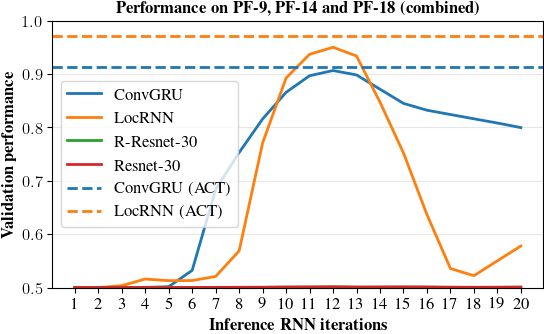

In [31]:
with open('paper_results/interpolation_locrnn_results.json', 'r') as filein:
    locrnn = json.load(filein)
with open('paper_results/interpolation_results.json', 'r') as filein:
    convgru = json.load(filein)
with open('paper_results/interpolation_resnet_results.json', 'r') as filein:
    resnet = json.load(filein)
results = {}
results.update(locrnn)
results.update(convgru)
results.update(resnet)

fig, ax = plt.subplots(1, 1)
ax.set_xticks(ticks=range(20), labels=range(1,21))
ax.plot(range(20), results['ConvGRU'], label='ConvGRU', linestyle='-', linewidth=2)
ax.plot(range(20), results['LocRNN'], label='LocRNN', linestyle='-', linewidth=2)
ax.plot(range(20), results['R-Resnet-30'], label='R-Resnet-30', linestyle='-', linewidth=2)
ax.plot(range(20), results['R-Resnet-30'], label='Resnet-30', linestyle='-', linewidth=2)
plt.axhline(y=0.9122, color='C0', label='ConvGRU (ACT)', linestyle='--', linewidth=2)
ax.axhline(y=0.9713, color='C1', label='LocRNN (ACT)', linestyle='--', linewidth=2)

# plt.vline(12)
ax.grid('on', axis='y', alpha=0.3)
ax.legend(fontsize=12, loc='center left')
ax.tick_params(axis='both', labelsize=12, )
ax.set_ylim([0.5, 1.0])
ax.set_xlabel(r"\textbf{Inference RNN iterations}", fontsize=12)
ax.set_ylabel(r"\textbf{Validation performance}", fontsize=12)
ax.set_title(r"\textbf{Performance on PF-9, PF-14 and PF-18 (combined)}", fontsize=12)

Text(0.5, 1.0, '\\textbf{Performance on held out PathFinder-21}')

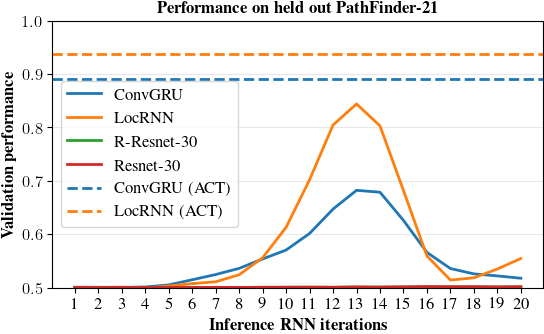

In [71]:
with open('paper_results/extrapolation21_locrnn_results.json', 'r') as filein:
    locrnn = json.load(filein)
with open('paper_results/extrapolation21_results.json', 'r') as filein:
    convgru = json.load(filein)
with open('paper_results/extrapolation21_resnet_results.json', 'r') as filein:
    resnet = json.load(filein)
results = {}
results.update(locrnn)
results.update(convgru)
results.update(resnet)

fig, ax = plt.subplots(1, 1)
ax.set_xticks(ticks=range(20), labels=range(1,21))
ax.plot(range(20), results['ConvGRU'], label='ConvGRU', linestyle='-', linewidth=2)
ax.plot(range(20), results['LocRNN'], label='LocRNN', linestyle='-', linewidth=2)
ax.plot(range(20), results['R-Resnet-30'], label='R-Resnet-30', linestyle='-', linewidth=2)
ax.plot(range(20), results['R-Resnet-30'], label='Resnet-30', linestyle='-', linewidth=2)
plt.axhline(y=0.8914, color='C0', label='ConvGRU (ACT)', linestyle='--', linewidth=2)
ax.axhline(y=0.93794, color='C1', label='LocRNN (ACT)', linestyle='--', linewidth=2)

# plt.vline(12)
ax.grid('on', axis='y', alpha=0.3)
# ax.axvspan(12, 21, alpha=0.2, color='gray')
ax.legend(fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim([0.5, 1.0])
ax.set_xlabel(r"\textbf{Inference RNN iterations}", fontsize=12)
ax.set_ylabel(r"\textbf{Validation performance}", fontsize=12)
ax.set_title(r"\textbf{Performance on held out PathFinder-21}", fontsize=12)

Text(0.5, 1.0, '\\textbf{Performance on held out PathFinder-24}')

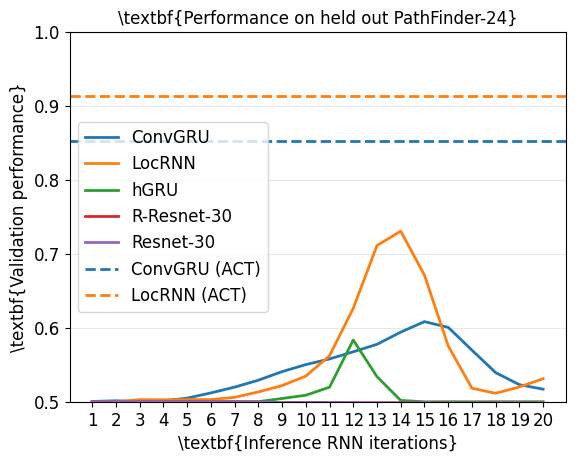

In [118]:
with open('paper_results/extrapolation24_locrnn_results.json', 'r') as filein:
    locrnn = json.load(filein)
with open('paper_results/extrapolation24_results.json', 'r') as filein:
    convgru = json.load(filein)
with open('paper_results/extrapolation24_resnet_results.json', 'r') as filein:
    resnet = json.load(filein)
with open('paper_results/extrapolation24_hgru_results.json', 'r') as filein:
    hgru = json.load(filein)
    
results = {}
results.update(locrnn)
results.update(convgru)
results.update(resnet)
results.update(hgru)


fig, ax = plt.subplots(1, 1)
ax.set_xticks(ticks=range(20), labels=range(1,21))
ax.plot(range(20), results['ConvGRU'], label='ConvGRU', linestyle='-', linewidth=2)
ax.plot(range(20), results['LocRNN'], label='LocRNN', linestyle='-', linewidth=2)
ax.plot(range(20), results['hGRU'], label='hGRU', linestyle='-', linewidth=2)
ax.plot(range(20), results['R-Resnet-30'], label='R-Resnet-30', linestyle='-', linewidth=2)
ax.plot(range(20), results['R-Resnet-30'], label='Resnet-30', linestyle='-', linewidth=2)
plt.axhline(y=0.85317, color='C0', label='ConvGRU (ACT)', linestyle='--', linewidth=2)
ax.axhline(y=0.91372, color='C1', label='LocRNN (ACT)', linestyle='--', linewidth=2)

# plt.vline(12)
ax.grid('on', axis='y', alpha=0.3)
# ax.axvspan(12, 21, alpha=0.2, color='gray')
ax.legend(fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim([0.5, 1.0])
ax.set_xlabel(r"\textbf{Inference RNN iterations}", fontsize=12)
ax.set_ylabel(r"\textbf{Validation performance}", fontsize=12)
ax.set_title(r"\textbf{Performance on held out PathFinder-24}", fontsize=12)

Text(0.5, 1.0, '(Approx) Contribution of output by each timestep')

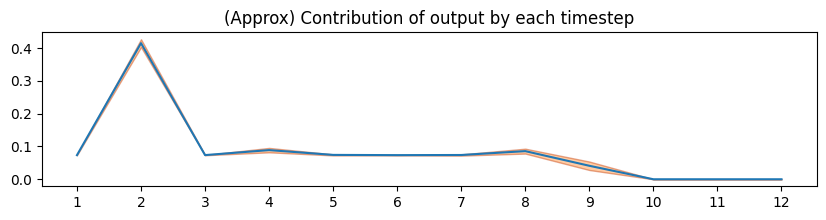

In [20]:
plt.figure(figsize=(10,2))
means = all_halt_probs.mean(axis=0)
stddevs = all_halt_probs.std(axis=0)
plt.plot(range(1,13), means)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep')

Counter({6: 77827, 7: 20620, 5: 1450, 8: 103})


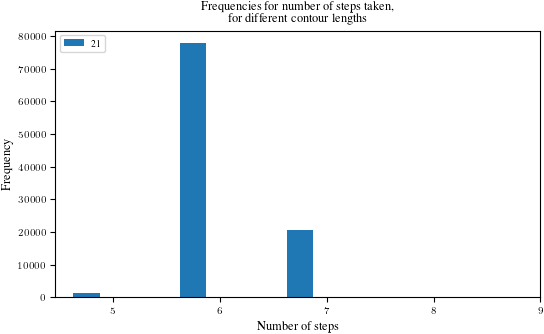

In [20]:
alpha_val = 1
fig, axs = plt.subplots(1, 1)
width = 0.25

halt_probs_of_interest = all_halt_probs
num_steps_run = (halt_probs_of_interest != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs.bar((np.array(num_steps) - width), freq, width=width, alpha=alpha_val)
print(Counter(num_steps_run.tolist()))

axs.set_xlabel('Number of steps')
axs.set_ylabel('Frequency')
axs.set_title('Frequencies for number of steps taken, \n for different contour lengths')
axs.set_xticks([5,6,7,8,9])
axs.legend(['21'],loc='upper left')

In [ ]:
incorrect_gt_true_idxs = torch.where(((outputs.argmax(dim=-1) != targets)) * (targets==0))[0]
incorrect_gt_false_idxs = torch.where(((outputs.argmax(dim=-1) != targets)) * (targets==1))[0]
correct_gt_true_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==0))[0]
correct_gt_false_idxs = torch.where(((outputs.argmax(dim=-1) == targets)) * (targets==1))[0]

incorrect_gt_false_probs = all_halt_probs[incorrect_gt_false_idxs]
incorrect_gt_true_probs = all_halt_probs[incorrect_gt_true_idxs]
correct_gt_false_probs = all_halt_probs[correct_gt_false_idxs]
correct_gt_true_probs = all_halt_probs[correct_gt_true_idxs]

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(6,6))

num_steps_run = (incorrect_gt_true_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[0,0].bar(num_steps, freq)
axs[0,0].set_xlabel('Number of steps')
axs[0,0].set_ylabel('Frequency')
axs[0,0].set_title('GT True, Incorrect')
print(Counter(num_steps_run.tolist()))

num_steps_run = (incorrect_gt_false_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[0, 1].bar(num_steps, freq)
axs[0, 1].set_xlabel('Number of steps')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_title('GT False, Incorrect')
print(Counter(num_steps_run.tolist()))

num_steps_run = (correct_gt_true_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[1, 0].bar(num_steps, freq)
axs[1, 0].set_xlabel('Number of steps')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_title('GT True, Correct')
print(Counter(num_steps_run.tolist()))

num_steps_run = (correct_gt_false_probs != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs[1, 1].bar(num_steps, freq)
axs[1, 1].set_xlabel('Number of steps')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('GT False, Correct')
print(Counter(num_steps_run.tolist()))


In [20]:
pos9 = torch.arange(0, 99992//2)
pos14 = torch.arange(99992//2, 99992)
pos18 = torch.arange(99992, 99992 + 99992 // 2)

neg9 = pos9 + (99992 * 3) // 2
neg14 = pos14 + (99992 * 3) // 2
neg18 = pos18 + (99992 * 3) // 2

contour_length9_idxs = torch.cat([pos9, neg9])
contour_length14_idxs = torch.cat([pos14, neg14])
contour_length18_idxs = torch.cat([pos18, neg18])

In [18]:
len(val_dataset), contour_length9_idxs.shape[0] + contour_length14_idxs.shape[0] + contour_length18_idxs.shape[0] 

(299976, 299976)

Counter({7: 59709, 6: 39948, 8: 335})
Counter({7: 63235, 8: 36732, 6: 14, 9: 11})
Counter({8: 92071, 9: 7904, 7: 17})


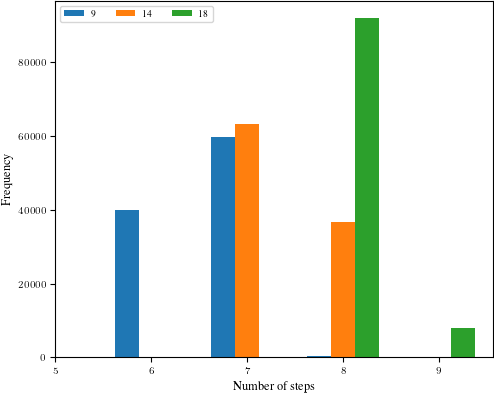

In [27]:
alpha_val = 1
fig, axs = plt.subplots(1, 1)
width = 0.25

halt_probs_of_interest = all_halt_probs[contour_length9_idxs]
num_steps_run = (halt_probs_of_interest != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs.bar((np.array(num_steps) - width), freq, width=width, alpha=alpha_val)
print(Counter(num_steps_run.tolist()))

halt_probs_of_interest = all_halt_probs[contour_length14_idxs]
num_steps_run = (halt_probs_of_interest != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs.bar((np.array(num_steps)).tolist(), freq, width=width, alpha=alpha_val)
print(Counter(num_steps_run.tolist()))

halt_probs_of_interest = all_halt_probs[contour_length18_idxs]
num_steps_run = (halt_probs_of_interest != 0).sum(dim=1).numpy()
num_steps, freq = zip(*Counter(num_steps_run.tolist()).items())
axs.bar((np.array(num_steps) + width).tolist(), freq, width=width, alpha=alpha_val)
print(Counter(num_steps_run.tolist()))

axs.set_xlabel('Number of steps')
axs.set_ylabel('Frequency')
# axs.set_title('Frequencies for number of steps taken, \n for different contour lengths')
axs.set_xticks([5,6,7,8,9])
axs.legend(['9', '14', '18'],loc='best', ncols=3)

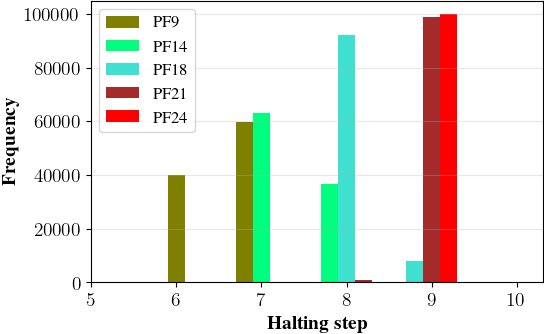

In [67]:
# LocRNN
## PFMixed9 
pf9 = Counter({6.8: 59709, 6: 39948, 7.7: 335})
pf14 = Counter({7: 63235, 7.8: 36732, 8.7: 11})
pf18 = Counter({8: 92071, 8.8: 7904, 7: 17})
## PF21
pf21 = Counter({9: 99011, 8.2: 987, 10: 2})
## PF24
pf24 = Counter({9.2: 99846, 10: 95, 8: 59})

alpha_val = 1
width = 0.2

fig, ax = plt.subplots(1, 1)

num_steps, freq = zip(*pf9.items())
ax.bar((np.array(num_steps)).tolist(), freq, width=width, alpha=alpha_val, color='olive', label='PF9')

num_steps, freq = zip(*pf14.items())
ax.bar((np.array(num_steps)).tolist(), freq, width=width, alpha=alpha_val, color='springgreen', label='PF14')

num_steps, freq = zip(*pf18.items())
ax.bar((np.array(num_steps)).tolist(), freq, width=width, alpha=alpha_val, color='turquoise', label='PF18')

num_steps, freq = zip(*pf21.items())
ax.bar((np.array(num_steps)).tolist(), freq, width=width, alpha=alpha_val, color='brown', label='PF21')

num_steps, freq = zip(*pf24.items())
ax.bar((np.array(num_steps)).tolist(), freq, width=width, alpha=alpha_val, color='red', label='PF24')

# plt.vline(12)
ax.grid('on', axis='y', alpha=0.3)
# ax.axvspan(12, 21, alpha=0.2, color='gray')
ax.legend(fontsize=12)
# ax.legend(['9', '14', '18'],loc='best', ncols=3)
ax.tick_params(axis='both', labelsize=14)
# ax.set_ylim([0.5, 1.0])
ax.set_xlabel(r"\textbf{Halting step}", fontsize=14)
ax.set_ylabel(r"\textbf{Frequency}", fontsize=14)
# ax.set_title(r"\textbf{Performance on held out PathFinder-24}", fontsize=12)

# axs.set_title('Frequencies for number of steps taken, \n for different contour lengths')
ax.set_xticks([5,6,7,8,9,10])

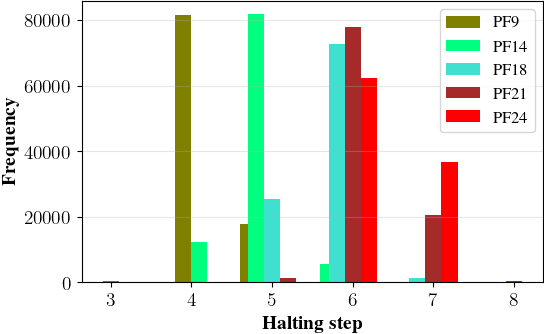

In [68]:
# ConvGRU
## PFMixed
pf9 = Counter({3.9: 81619, 4.7: 17915, 3: 349, 5.6: 109})
pf14 = Counter({4.8: 81808, 4.1: 12437, 5.7: 5744})
pf18 = Counter({5.8: 72883, 5: 25575, 6.8: 1499})
# PF21
pf21 = Counter({6: 77827, 7: 20620, 5.2: 1450})
# PF24
pf24 = Counter({6.2: 62460, 7.2: 36813, 8: 415})

alpha_val = 1
width = 0.2

fig, ax = plt.subplots(1, 1)

num_steps, freq = zip(*pf9.items())
ax.bar((np.array(num_steps)).tolist(), freq, width=width, alpha=alpha_val, color='olive', label='PF9')

num_steps, freq = zip(*pf14.items())
ax.bar((np.array(num_steps)).tolist(), freq, width=width, alpha=alpha_val, color='springgreen', label='PF14')

num_steps, freq = zip(*pf18.items())
ax.bar((np.array(num_steps)).tolist(), freq, width=width, alpha=alpha_val, color='turquoise', label='PF18')

num_steps, freq = zip(*pf21.items())
ax.bar((np.array(num_steps)).tolist(), freq, width=width, alpha=alpha_val, color='brown', label='PF21')

num_steps, freq = zip(*pf24.items())
ax.bar((np.array(num_steps)).tolist(), freq, width=width, alpha=alpha_val, color='red', label='PF24')

# plt.vline(12)
ax.grid('on', axis='y', alpha=0.3)
# ax.axvspan(12, 21, alpha=0.2, color='gray')
ax.legend(fontsize=12)
# ax.legend(['9', '14', '18'],loc='best', ncols=3)
ax.tick_params(axis='both', labelsize=14)
# ax.set_ylim([0.5, 1.0])
ax.set_xlabel(r"\textbf{Halting step}", fontsize=14)
ax.set_ylabel(r"\textbf{Frequency}", fontsize=14)
# ax.set_title(r"\textbf{Performance on held out PathFinder-24}", fontsize=12)

# axs.set_title('Frequencies for number of steps taken, \n for different contour lengths')
ax.set_xticks([3,4,5,6,7,8])

In [ ]:
plt.figure(figsize=(10,2))
means = all_halt_probs[contour_length9_idxs].mean(axis=0)
stddevs = all_halt_probs[contour_length9_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, Contour Length 9')

plt.figure(figsize=(10,2))
means = all_halt_probs[contour_length14_idxs].mean(axis=0)
stddevs = all_halt_probs[contour_length14_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, Contour Length 14')

plt.figure(figsize=(10,2))
means = all_halt_probs[contour_length18_idxs].mean(axis=0)
stddevs = all_halt_probs[contour_length18_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, Contour Length 18')

In [ ]:
plt.figure(figsize=(10,2))
means = all_halt_probs[contour_length9_idxs].mean(axis=0)
stddevs = all_halt_probs[contour_length9_idxs].std(axis=0)
plt.plot(range(1,13), means)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, Contour Length 9')

plt.figure(figsize=(10,2))
means = all_halt_probs[contour_length14_idxs].mean(axis=0)
stddevs = all_halt_probs[contour_length14_idxs].std(axis=0)
plt.plot(range(1,13), means)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, Contour Length 14')

plt.figure(figsize=(10,2))
means = all_halt_probs[contour_length18_idxs].mean(axis=0)
stddevs = all_halt_probs[contour_length18_idxs].std(axis=0)
plt.plot(range(1,13), means)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, Contour Length 18')

In [ ]:
plt.figure(figsize=(10,2))
means = state_magnitudes[contour_length9_idxs].mean(axis=0)
stddevs = state_magnitudes[contour_length9_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, Contour Length 9')

plt.figure(figsize=(10,2))
means = state_magnitudes[contour_length14_idxs].mean(axis=0)
stddevs = state_magnitudes[contour_length14_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, Contour Length 14')

plt.figure(figsize=(10,2))
means = state_magnitudes[contour_length18_idxs].mean(axis=0)
stddevs = state_magnitudes[contour_length18_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, Contour Length 18')

In [ ]:
plt.figure(figsize=(10,2))

# Halt probs weighted by mean abs value of state
normalized_contributions = all_halt_probs * state_magnitudes

means = normalized_contributions[contour_length9_idxs].mean(axis=0)
stddevs = normalized_contributions[contour_length9_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, Contour Length 9')

plt.figure(figsize=(10,2))
means = normalized_contributions[contour_length14_idxs].mean(axis=0)
stddevs = normalized_contributions[contour_length14_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, Contour Length 14')

plt.figure(figsize=(10,2))
means = normalized_contributions[contour_length18_idxs].mean(axis=0)
stddevs = normalized_contributions[contour_length18_idxs].std(axis=0)
plt.plot(range(1,13), means)
# plt.errorbar(range(1,13), means, yerr=stddevs)
plt.fill_between(range(1,13), means-stddevs, means+stddevs,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(range(1, 13))
plt.title('(Approx) Contribution of output by each timestep, Contour Length 18')

In [8]:
all_images = []
for x in tqdm(val_loader):
    inputs, _ = x
    all_images.append(inputs)
all_images = torch.cat(all_images, dim=0)
all_images = all_images[:, 0, :, :]

  3%|██▎                                                                                 | 32/1172 [00:50<30:11,  1.59s/it]

SystemError: <built-in function _error_if_any_worker_fails> returned a result with an error set

### Check if difficulty corresponds to number of steps

In [ ]:
# Within all 14 length contours, get 10 examples each of steps 6, 7 and 8
num_steps_run = (all_halt_probs != 0).sum(dim=1).numpy()
temp2 = set(contour_length14_idxs.tolist())

temp = np.where(num_steps_run==6)[0]
length14_step6_idxs = np.array([x for x in temp if x in temp2])
temp = np.where(num_steps_run==7)[0]
length14_step7_idxs = np.array([x for x in temp if x in temp2])
temp = np.where(num_steps_run==8)[0]
length14_step8_idxs = np.array([x for x in temp if x in temp2])

In [ ]:
sampled_step6_idxs = np.random.choice(length14_step6_idxs, size=5, replace=False)
sampled_step7_idxs = np.random.choice(length14_step7_idxs, size=5, replace=False)
sampled_step8_idxs = np.random.choice(length14_step8_idxs, size=5, replace=False)

In [ ]:
fig = plt.figure(figsize=(30,15))
for idx, x in enumerate(all_images[sampled_step6_idxs]):
    fig.add_subplot(3,5,idx+1)
    plt.imshow(x)
for idx, x in enumerate(all_images[sampled_step7_idxs]):
    fig.add_subplot(3,5,idx+6)
    plt.imshow(x)
for idx, x in enumerate(all_images[sampled_step8_idxs]):
    fig.add_subplot(3,5,idx+11)
    plt.imshow(x)

### Inspect state activations

In [3]:
model.readout, model.final_conv

NameError: name 'model' is not defined

In [19]:
k = 2  # replace with the desired number of samples

perm1 = torch.randperm(incorrect_gt_false_idxs.size(0))
subselected_incorrect_gt_false_idxs = incorrect_gt_false_idxs[perm1[:k]]
perm2 = torch.randperm(incorrect_gt_true_idxs.size(0))
subselected_incorrect_gt_true_idxs = incorrect_gt_true_idxs[perm2[:k]]

chosen_idxs = torch.cat([subselected_incorrect_gt_false_idxs, 
                        subselected_incorrect_gt_true_idxs])

# pos_idx = torch.tensor(np.random.choice(pos14, 2))
# neg_idx = torch.tensor(np.random.choice(neg14, 2))
# chosen_idxs = torch.cat([pos_idx, neg_idx])
print(chosen_idxs)

tensor([185059, 251788,  49725, 123051])


In [20]:
subset_val_loader = torch.utils.data.DataLoader(
        torch.utils.data.Subset(val_dataset, chosen_idxs),
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)

In [21]:
for x in tqdm(subset_val_loader):
    inputs, _ = x
    all_images = inputs
all_images = all_images[:, 0, :, :]

100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


In [22]:
# We apply the final layer (32 x 1) to each point in the 32 x 40 x 40 state vector at each timepoint. Gives us a 40 x 40 image
model.eval()
for i, (images, target) in tqdm(enumerate(subset_val_loader)):
        images = images.cuda(args.gpu, non_blocking=True)
        x, gates, halt_probs, ponder_cost = model.backbone(images)
        s_exc, s_inh = torch.stack(x[0]), torch.stack(x[1])
        g_exc, g_inh = torch.stack(gates[0]), torch.stack(gates[1])
        
        exc_state_activations = s_exc
        inh_state_activations = s_inh
        exc_gate_activations = g_exc
        inh_gate_activations = g_inh
        all_halt_probs = halt_probs

0it [00:00, ?it/s]/home/AD/srravishankar/anaconda3/envs/pytorch_111/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
1it [00:00,  2.27it/s]


#### Inspect what the channels are doing separately

In [ ]:
num_timesteps, bs, nc, d1, d2 = exc_state_activations.shape

example_idx = 2
channel_idx = 4
x1 = exc_state_activations[:, example_idx, channel_idx, :, :].detach().cpu().numpy()
x2 = inh_state_activations[:, example_idx, channel_idx, :, :].detach().cpu().numpy()

fig = plt.figure(figsize=(20, 4))
num_timesteps_shown = 9
nrows = 2
ncols = num_timesteps_shown + 1

# Row 1, exc state
idx = 0

fig.add_subplot(nrows, ncols, 1 + (ncols * idx))
plt.imshow(all_images[example_idx])    
plt.xticks([])
plt.yticks([])

for timestep in range(num_timesteps_shown):
    fig.add_subplot(nrows, ncols, timestep + 2 + (ncols * idx))
    plt.imshow(x1[timestep, :, :], cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    # plt.title('{:.2f}'.format(all_halt_probs[example_idx, timestep].item()))

# Row 2, inh state
idx = 1

fig.add_subplot(nrows, ncols, 1 + (ncols * idx))
plt.imshow(all_images[example_idx])    
plt.xticks([])
plt.yticks([])
    
for timestep in range(num_timesteps_shown):
    fig.add_subplot(nrows, ncols, timestep + 2 + (ncols * idx))
    plt.imshow(x2[timestep, :, :], cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    # plt.title('{:.2f}'.format(all_halt_probs[example_idx, timestep].item()))


#### Inspect what the average of the channels are encoding

In [23]:
# average (over channels) excitatory state activations 
x = exc_state_activations
num_timesteps, bs, nc, d1, d2 = x.shape
x1 = x.mean(axis=2)
x1 = x1.transpose(0,1).detach().cpu().numpy()

# average (over channels) inhibitory state activations
x = inh_state_activations
num_timesteps, bs, nc, d1, d2 = x.shape
x2 = x.mean(axis=2)
x2 = x2.transpose(0,1).detach().cpu().numpy()

# average (over channels) excitatory gate activations
x = exc_gate_activations
num_timesteps, bs, nc, d1, d2 = x.shape
x3 = x.mean(axis=2)
x3 = x3.transpose(0,1).detach().cpu().numpy()

# average (over channels) inhibitory gate activations
x = inh_gate_activations
num_timesteps, bs, nc, d1, d2 = x.shape
x4 = x.mean(axis=2)
x4 = x4.transpose(0,1).detach().cpu().numpy()

In [24]:
x1.shape, x2.shape, x3.shape, all_halt_probs.shape

((4, 12, 40, 40), (4, 12, 40, 40), (4, 12, 40, 40), torch.Size([4, 12]))

In [58]:
example_idx = 3 # np.random.choice(len(chosen_idxs))
print(chosen_idxs[example_idx])

tensor(123051)


In [59]:
chosen_idxs

tensor([185059, 251788,  49725, 123051])

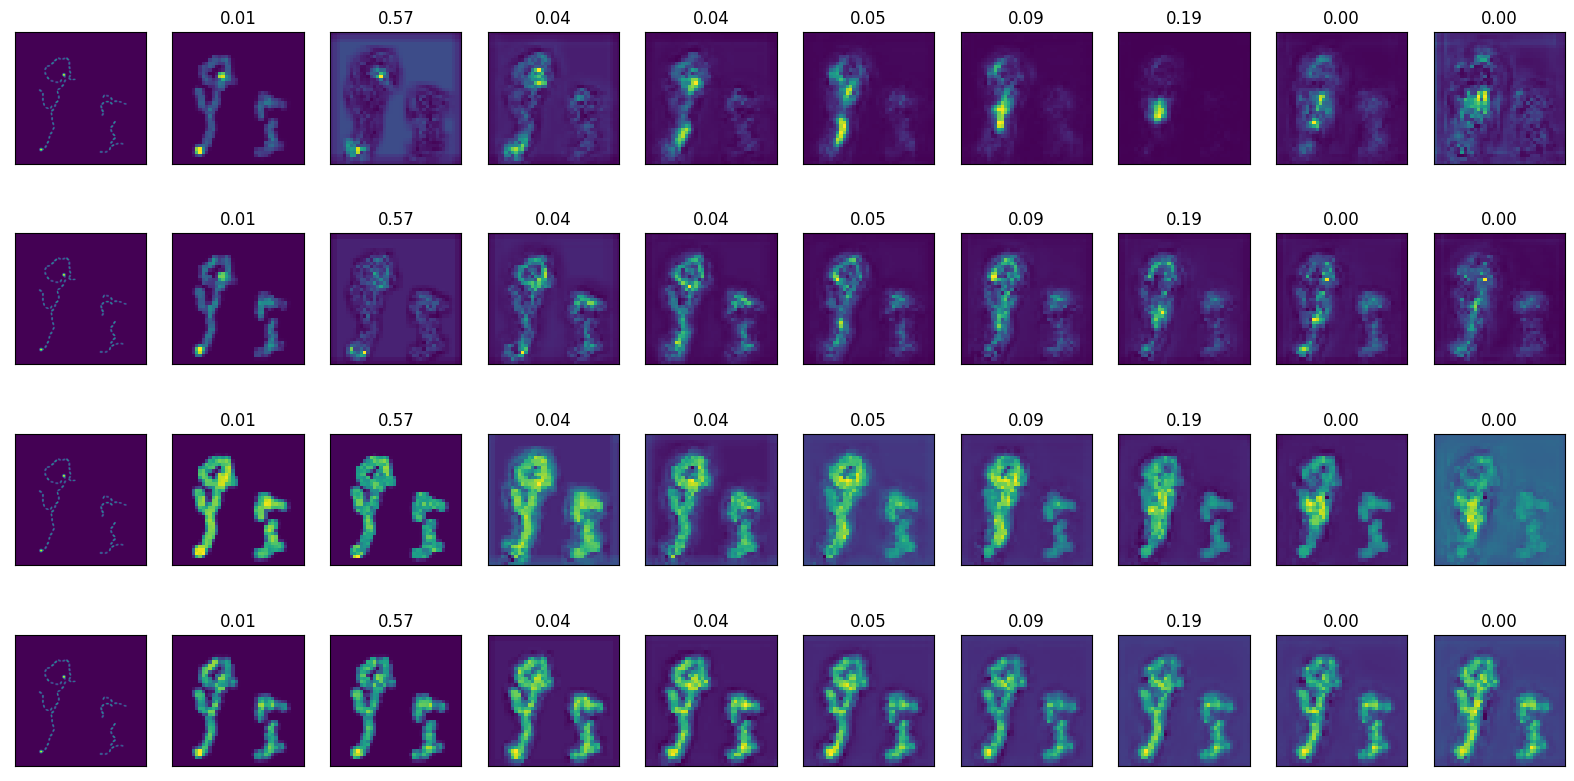

In [60]:
fig = plt.figure(figsize=(20, 10))
num_timesteps_shown = 9
nrows = 4
ncols = num_timesteps_shown + 1

# Row 1, exc state
idx = 0

fig.add_subplot(nrows, ncols, 1 + (ncols * idx))
plt.imshow(all_images[example_idx])    
plt.xticks([])
plt.yticks([])

for timestep in range(num_timesteps_shown):
    fig.add_subplot(nrows, ncols, timestep + 2 + (ncols * idx))
    plt.imshow(x1[example_idx, timestep, :, :], cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title('{:.2f}'.format(all_halt_probs[example_idx, timestep].item()))

# Row 2, inh state
idx = 1

fig.add_subplot(nrows, ncols, 1 + (ncols * idx))
plt.imshow(all_images[example_idx])    
plt.xticks([])
plt.yticks([])
    
for timestep in range(num_timesteps_shown):
    fig.add_subplot(nrows, ncols, timestep + 2 + (ncols * idx))
    plt.imshow(x2[example_idx, timestep, :, :], cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title('{:.2f}'.format(all_halt_probs[example_idx, timestep].item()))

# Row 3, exc gate
idx = 2

fig.add_subplot(nrows, ncols, 1 + (ncols * idx))
plt.imshow(all_images[example_idx])    
plt.xticks([])
plt.yticks([])
    
for timestep in range(num_timesteps_shown):
    fig.add_subplot(nrows, ncols, timestep + 2 + (ncols * idx))
    plt.imshow(x3[example_idx, timestep, :, :], cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title('{:.2f}'.format(all_halt_probs[example_idx, timestep].item()))

# Row 4, inh gate
idx = 3

fig.add_subplot(nrows, ncols, 1 + (ncols * idx))
plt.imshow(all_images[example_idx])    
plt.xticks([])
plt.yticks([])
    
for timestep in range(num_timesteps_shown):
    fig.add_subplot(nrows, ncols, timestep + 2 + (ncols * idx))
    plt.imshow(x4[example_idx, timestep, :, :], cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title('{:.2f}'.format(all_halt_probs[example_idx, timestep].item()))

In [68]:
example_idx = np.random.choice(len(chosen_idxs))
print(chosen_idxs[example_idx])

tensor(202276)


(-0.5, 159.5, 159.5, -0.5)

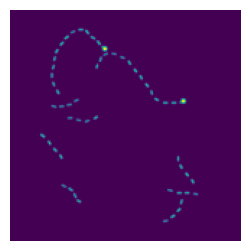

In [69]:
from PIL import Image
from matplotlib import cm

# Only states, not gates

num_timesteps_shown = 9
nrows = 2
ncols = num_timesteps_shown + 1

plt.figure(figsize=(3, 3))
plt.imshow(all_images[example_idx])
plt.axis('off')

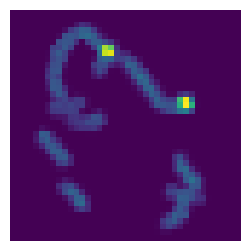

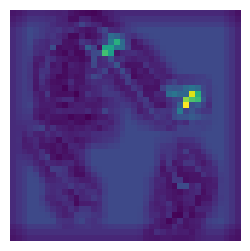

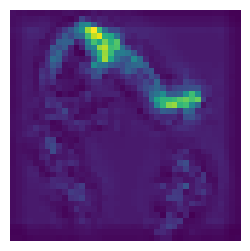

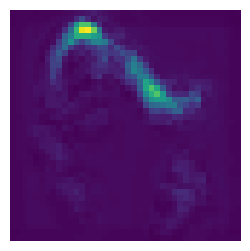

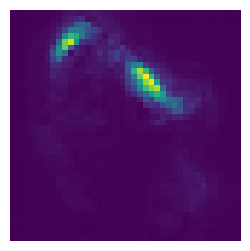

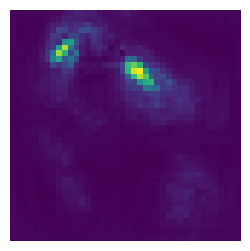

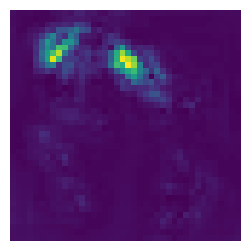

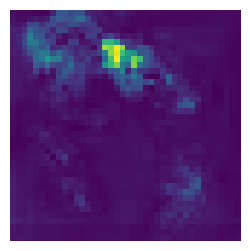

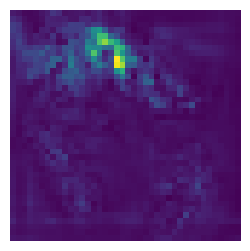

In [70]:
for timestep in range(num_timesteps_shown):
    plt.figure(figsize=(3, 3))
    plt.imshow(x1[example_idx, timestep, :, :], cmap='viridis')
    plt.axis('off')

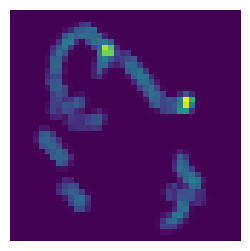

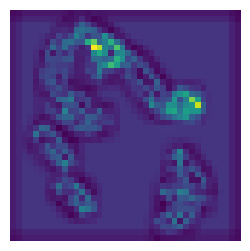

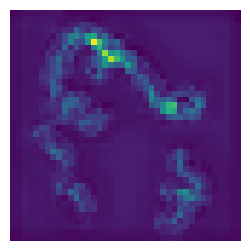

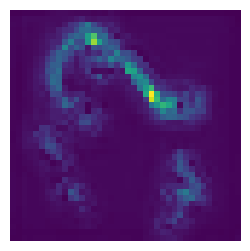

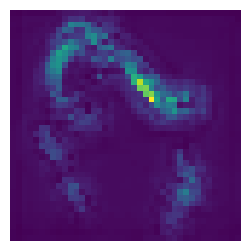

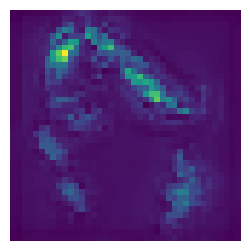

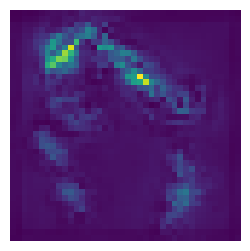

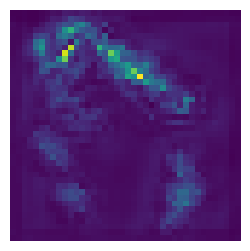

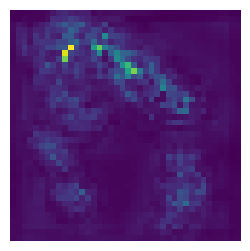

In [73]:
for timestep in range(num_timesteps_shown):
    plt.figure(figsize=(3, 3))
    plt.imshow(x2[example_idx, timestep, :, :], cmap='viridis')
    plt.axis('off')

# Creating plots for NeurIPS 23

In [4]:
from tueplots import bundles
bundles.neurips2022()
# bundles.icml2022(family="sans-serif", usetex=False, column="full", nrows=2)
bundles.neurips2022(family="sans-serif", usetex=False)

plt.rcParams.update(bundles.neurips2022())
plt.rcParams.fontsize = 12

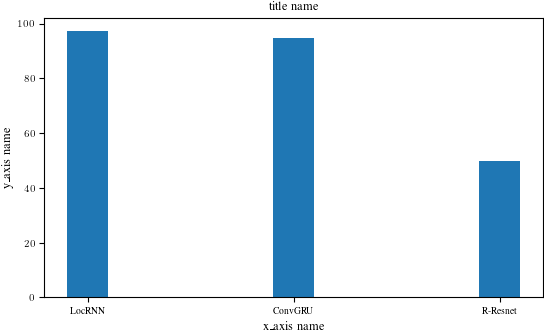

In [14]:
x_axis = ['LocRNN', 'ConvGRU', 'R-Resnet']
y_axis = [97.3, 94.6, 50.0]

plt.bar(x_axis, y_axis, width=0.2)
plt.title('title name')
plt.xlabel('x_axis name')
plt.ylabel('y_axis name')
plt.show()

## Force number of inference iterations for non-ACT models